<a href="https://colab.research.google.com/github/janchorowski/nn_assignments/blob/nn18/assignment5/Assignment5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Submission deadline:**
* **Last lab session before or on Friday, 04.01.19**

**Points: 10 + 4 bonus points**

Please note: some of the assignments are tedious or boring if you are already a NumPy ninja. The bonus problems were designed to give you a more satisfying alternative.

The assignment is in the form of a Jupyter notebook. We will be using [Google Colab](https://colab.research.google.com) to solve it. Below you will find a "Setup" section. Follow instructions from this paragraph to download the notebook and open it using [Google Colab](https://colab.research.google.com). 

Your goal is to solve problems posted below. Whenever possible, add your solutions to the notebook.

Please email us about any problems with it - we will try to correct them quickly. Also, please do not hesitate to use GitHub’s pull requests to send us corrections!

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [0]:
# Please note that this code needs only to be run in a fresh runtime.
# However, it can be rerun afterwards too.
!pip install -q gdown httpimport
!pip install -q --no-cache-dir -I pillow

In [0]:
# Common imports

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [0]:
# Torch has to go first due to an importing bug
import torch

import collections
import os
import re

import numpy as np
import scipy.io
import scipy.ndimage

import PIL

import logging
logging.getLogger("PIL").setLevel(logging.INFO)

from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision

import httpimport
with httpimport.github_repo('janchorowski', 'nn_assignments', 
                            module='common', branch='nn18'):
    import common.plotting

In [0]:
# We strongly recommend training using CUDA
CUDA = True

def to_np(x):
    return x.detach().cpu().numpy()

def to_tensor(x, **kwargs):
    x = torch.from_numpy(x)
    if CUDA:
        x = x.cuda()
    return torch.tensor(x, **kwargs)

# Problem 1: Understanding the VGG network [4p]

In this task we will load a pre-trained model of the [VGG network](http://www.robots.ox.ac.uk/~vgg/research/very_deep/). It's a convolutional network developed at the Oxford University, trained on the [Imagenet Large Scale Visual Recognition Challenge 2012 (ILSVRC2012)](http://image-net.org/challenges/LSVRC/2012/) classificatiom dataset of 1.2 million training images of 1000 classes. A few VGG models of different depth have been proposed. The diagram below presents VGG16. Details of those models: [Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/abs/1409.1556) by Simonyan and Zisserman.

![vgg16](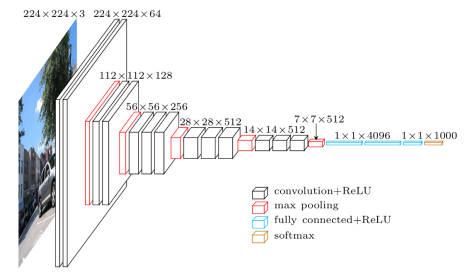
)

We will investigate how VGG classifies images, and 
try to build a deeper understanding of which parts of
a particular input image influence the output of the network.
We will start by simply occluding parts of the image
with a square of zeros anchored at point $(i, j)$ ,
and analyzing how the signal propagated through the network changes.
Becuase pre-processing for VGG requires to subtract the mean,
the most neutral occluding squares will appear grey when pre-processing is reversed.
Further reading: [Visualizing and Understanding Convolutional Networks](https://arxiv.org/abs/1311.2901)
by Zeiler and Fergus.

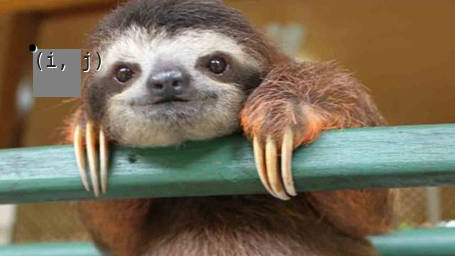

Let $X^{L:m}_{(k,l)}$ denote the input image tensor procesed by 
the $m$-th map of layer $L$,
where $(k, l)$ denote position in the map. To complete the assignment:
1. **[1p]** Load a pre-trained model of a VGG network (e.g., VGG-19) and inspect its architecture.
  Classify at least 5 images of your
  choice and plot them along with top-5 predictions returned by the network. We provide a mapping from
  numerical class labels to textual descriptions.
  It is vital to apply the same pre-processing as the one which has been used during network training.
2. **[2p]** Implement and test heatmaps generated by iteratively occluding parts of the input image.
  * Implement a data iterator which takes an input image and iteratively occludes part of the image with a
    rectangle (see sample image above).
  * Implement a function `layer_activations(x, layer_name)` of
    the VGG network class,
    which taps into the network and returns activations of a chosen layer. 
    For each occluding position $(i, j)$ in the input image, we can record 
    sum of activations of feature map $m$ in layer $L$ as a heatmap
    $h^{L:m}_{(i,j)} = \sum_{k,l} X^{L:m}_{(k,l)}$. Moving around the occluding rectangle
    changes the activations. Plot heatmaps $h^{L:m}$ for
    a few selected layers and images.
  * For each occluding position $(i, j)$ in the input image, we can record
    output probability of the true class $C$ and store it as $p(C|i,j)$.
    Plot such probability maps for a few images. Plot maps of network predictions
    $\text{argmax}_c p(c|i,j)$, which should reveal which occluding positions
    change the prediction of the network.
3. **[1p]** The method of [Integrated Gradients](https://arxiv.org/abs/1703.01365)
    allows to track which input pixels influence predictions of the network.
    Complete the code and run the method on a couple of examples.

In [0]:
![ -e ilsvrc_subsample.tar.bz2 ] || gdown 'https://drive.google.com/uc?id=1Y9xfTe9rjvFiX5N9DZqCRm83zHtQUBDC' -O ilsvrc_subsample.tar.bz2
![ -d ilsvrc_subsample ] || tar jxf ilsvrc_subsample.tar.bz2

In [0]:
class ILSVRC2014Sample(object):
    """Mapper from numerical class IDs to their string LABELS and DESCRIPTIONS.
    
    Please use the dicts:
    - id_to_label and label_to_id to convert string labels and numerical ids
    - label_to_desc to get a textual description of a class label
    - id_to_desc to directly get descriptions for numerical IDs
    
    """
    def load_image(self, path):
        img = PIL.Image.open(path)
        img = img.convert('RGB')
        for t in self.transforms:
            img = t(img)
        return numpy.asarray(img).astype('float32') / 255.0
    
    def __init__(self, num=100):
        self.transforms = [
            torchvision.transforms.Resize(256),
            torchvision.transforms.CenterCrop(224)]
        
        base_dir = 'ilsvrc_subsample/'
        devkit_dir = base_dir
        
        meta = scipy.io.loadmat(devkit_dir + '/meta.mat')
        imagenet_class_names = []
        self.label_to_desc = {}
        for i in range(1000):
            self.label_to_desc[meta['synsets'][i][0][1][0]] = meta['synsets'][i][0][2][0]
            imagenet_class_names.append(meta['synsets'][i][0][1][0])
        
        img_names = sorted(os.listdir(base_dir + '/img'))[:num]
        img_ids = {int(re.search('\d{8}', name).group()) for name in img_names}
        with open(devkit_dir + '/ILSVRC2012_validation_ground_truth.txt', 'r') as f:
            self.labels = [imagenet_class_names[int(line.strip()) - 1] \
                           for i, line in enumerate(f) if i+1 in img_ids]
        self.data = [self.load_image(base_dir + '/img/' + name)
                     for name in img_names]
        
        self.id_to_label = sorted(self.label_to_desc.keys())
        self.label_to_id = {}
        self.id_to_desc = []
        for id_, label in enumerate(self.id_to_label):
            self.label_to_id[label] = id_
            self.id_to_desc.append(self.label_to_desc[label])

In [0]:
#
# TODO: fill in the blanks in the VGG network. The function multi_layer_activations
# is only needed for the last homework.
#



class VGGPreprocess(torch.nn.Module):
    """Pytorch module that normalizes data for a VGG network
    """
    # These values are taken from http://pytorch.org/docs/master/torchvision/models.html
    RGB_MEANS = torch.FloatTensor([0.485, 0.456, 0.406])[None, :, None, None]
    RGB_STDS = torch.FloatTensor([0.229, 0.224, 0.225])[None, :, None, None]
    
    def forward(self, x):
        """Normalize a single image or a batch of images
        
        Args:
            x: a pytorch Variable containing and float32 RGB image tensor with 
              dimensions (batch_size x width x heigth x RGB_channels) or 
              (width x heigth x RGB_channels).
        Returns:
            a torch Variable containing a normalized BGR image with shape 
              (batch_size x BGR_channels x width x heigth)
        """
        if x.dim() == 3:
            x = torch.unsqueeze(x, 0)
        # x is batch * width * heigth *channels,  
        # make it batch * channels * width * heigth 
        if x.size(3) == 3:
            x = x.permute(0, 3, 1, 2)
        means = self.RGB_MEANS
        stds = self.RGB_STDS
        if x.is_cuda:
            means = means.cuda()
            stds = stds.cuda()
        x = (x - Variable(means)) / Variable(stds)
        return x


class VGG(torch.nn.Module):
    """Wrapper around a VGG network allowing convenient extraction of layer activations.
    
    """
    FEATURE_LAYER_NAMES = {
        'vgg16':
            ["conv1_1", "relu1_1", "conv1_2", "relu1_2", "pool1"
             "conv2_1", "relu2_1", "conv2_2", "relu2_2", "pool2"
             "conv3_1", "relu3_1", "conv3_2", "relu3_2", "conv3_3",
             "relu3_3", "pool3"
             "conv4_1", "relu4_1", "conv4_2", "relu4_2", "conv4_3",
             "relu4_3", "pool4"
             "conv5_1", "relu5_1", "conv5_2", "relu5_2", "conv5_3",
             "relu5_3", "pool5"],
        'vgg19':
            ["conv1_1", "relu1_1", "conv1_2", "relu1_2", "pool1",
             "conv2_1", "relu2_1", "conv2_2", "relu2_2", "pool2",
             "conv3_1", "relu3_1", "conv3_2", "relu3_2", "conv3_3",
             "relu3_3", "conv3_4", "relu3_4", "pool3",
             "conv4_1", "relu4_1", "conv4_2", "relu4_2",
             "conv4_3", "relu4_3", "conv4_4", "relu4_4", "pool4",
             "conv5_1", "relu5_1", "conv5_2", "relu5_2",
             "conv5_3", "relu5_3", "conv5_4", "relu5_4", "pool5"]}
    
    def __init__(self, model='vgg19'):
        super(VGG, self).__init__()
        all_models = {'vgg16': torchvision.models.vgg16,
                      'vgg19': torchvision.models.vgg19}   
        vgg = all_models[model](pretrained=True)
        
        self.preprocess = VGGPreprocess()
        self.features = vgg.features
        self.classifier = vgg.classifier
        self.softmax = torch.nn.Softmax(dim=-1)
        
        self.feature_names = self.FEATURE_LAYER_NAMES[model]
        
        assert len(self.feature_names) == len(self.features)

    def forward(self, x):
        """ Return pre-softmax unnormalized logits. 
        """
        x = self.preprocess(x)
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    
    def probabilities(self, x):
        """Return class probabilities.
        """
        logits = self(x)
        return TODO
        
    def layer_activations(self, x, layer_name):
        """Return activations of a selected layer.
        """
        x = self.preprocess(x)
        for name, layer in zip(self.feature_names, self.features):
            x = layer(x)
            if name == layer_name:
                return x
        raise ValueError('Layer %s not found' % layer_name)
    
    def multi_layer_activations(self, x, layer_names):
        """Return activations of all requested layers.
        """
        # TODO: implement me!
        pass

    def predict(self, x):
        """Return predicted class IDs.
        """
        logits = self(x)
        return TODO
    
vgg = VGG('vgg19')

if CUDA:
    vgg.cuda()

In [0]:
# List layers in the model
print 'Feature layers'
print '--------------'
for name, layer in zip(vgg.feature_names, vgg.features):
    print '{1: <12} {0: <8}  ({2}'.format(name, *str(layer).split('(', 1))
print '\nClassifier layers'
print '-----------------'
for layer in vgg.classifier:
    print '{: <12}({}'.format(*str(layer).split('(', 1))

Feature layers
--------------
Conv2d       conv1_1   (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu1_1   (inplace)
Conv2d       conv1_2   (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu1_2   (inplace)
MaxPool2d    pool1     (kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d       conv2_1   (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu2_1   (inplace)
Conv2d       conv2_2   (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu2_2   (inplace)
MaxPool2d    pool2     (kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d       conv3_1   (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu3_1   (inplace)
Conv2d       conv3_2   (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu3_2   (inplace)
Conv2d       conv3_3   (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU 

/usr/local/lib/python2.7/dist-packages/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


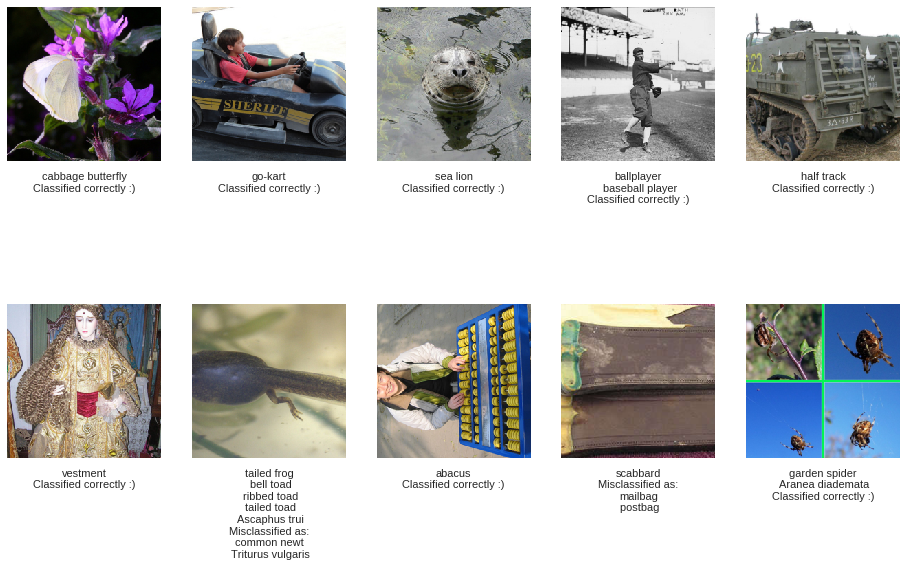

In [0]:
ilsvrc = ILSVRC2014Sample(40)
vgg.eval()

figsize(16, 10)
for i in range(10):
    img = ilsvrc.data[30 + i]
    label = ilsvrc.labels[30 + i]

    img_torch = to_tensor(img)
    predicted_label_id = to_np(vgg.predict(img_torch))[0]
    predicted_label = ilsvrc.id_to_label[predicted_label_id]
    
    desc = ilsvrc.label_to_desc[label].split(',')
    if label == predicted_label:
        desc.append('Classified correctly :)')
    else:
        desc.append('Misclassified as:')
        desc.extend(ilsvrc.label_to_desc[predicted_label].split(','))
    
    ax = subplot(2, 5, 1 + i)
    ax.set_xlabel('\n'.join(desc)) #, {'verticalalignment': 'bottom'})
    ax.set_xticklabels([], visible=False)
    ax.set_yticklabels([], visible=False)
    ax.tick_params(axis='both', which='both', bottom='off', left='off', top='off')
    ax.grid(False)
    imshow(img)

## Implement classification of your own images below

## Analyse the responses of the network when part of the input is obscured

In [0]:
# TODO
# Implement a generator of minibatches which have partial obstructions
# The generator should yield batches of size 'bsz'

def obscured_imgs(img, boxsize=8, bsz=64, stride=4):
    pass

/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


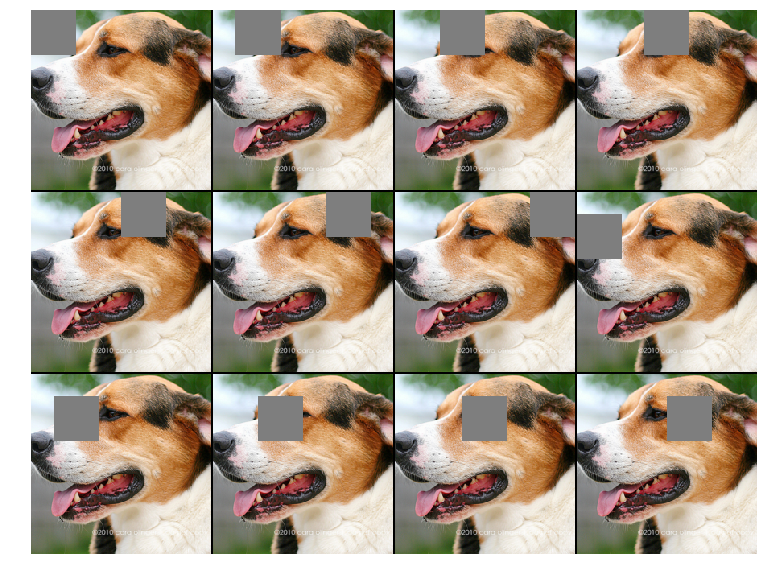

In [0]:
# Show samples from an obscured batch
batch = obscured_imgs(ilsvrc.data[27], boxsize=56, bsz=12, stride=28).next()
batch = np.vstack([im[None] for im in batch])

common.plotting.plot_mat(batch.transpose(0, 3, 1, 2))

In [0]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

In [0]:
idx = 32
img = ilsvrc.data[idx]
label = ilsvrc.labels[idx] 

# if you run out of GPU mem split batch into smaller ones
bsz = 64
boxsize = 52
stride = 14

vgg.eval()

# Accumulate activations for activation heatmap,
# true class probability map, network prediction map
map_types = ['heat', 'prob', 'pred']
maps = {mt: [] for mt in map_types}
for batch in obscured_imgs(img, boxsize, bsz, stride):    
    with torch.no_grad():
        batch = to_tensor(batch)
        # TODO choose a layer and a neuron. Aggregate its activations across all locations in the image
        # The sample code used layer conv2_1 an dneuron #1
        maps['heat'].append(to_np(vgg.layer_activations(batch, TODO))[:, 1].sum(axis=(1, 2)))
        # TODO record the probability assigned to the correct class
        maps['prob'].append(TODO)
        # TODO record the network predictions
        maps['pred'].append(TODO)
    
for k in maps:
    maps[k] = np.concatenate(maps[k])
    maps[k] = maps[k].reshape(int(np.sqrt(maps[k].shape[0])), -1)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


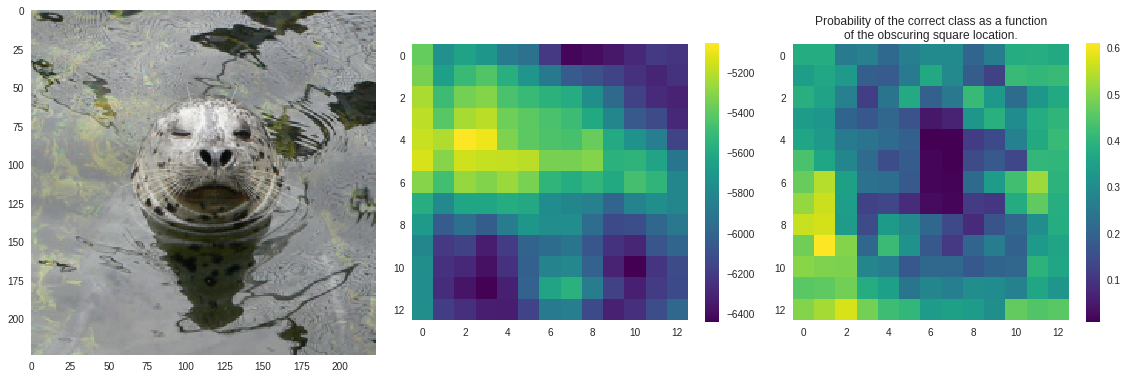

In [0]:
#
# This image recreates figure 7 from M. Zieler et al.
# Visualizing and Understanding Convolutional Neural Networks
# https://arxiv.org/pdf/1311.2901.pdf
#

figure(figsize(16, 10))
subplot(2, 2, 1)
imshow(img)
grid(False)
title('Original Image')

subplot(2, 2, 2)
imshow(maps['heat'], cmap='viridis')
grid(False)
colorbar()
title('Magnitude of activations in a selected layer\n'
      'As a function of the obscuring square location')

subplot(2, 2, 3)
imshow(maps['prob'], cmap='viridis')
grid(False)
colorbar()
title('Probability of the correct class as a function\n'
      'of the obscuring square location.')

subplot(2, 2, 4)
discrete = np.zeros_like(maps['pred'], dtype=np.int64)
values = np.unique(maps['pred']).astype(np.int64)
for i, v in enumerate(values):
    discrete[np.where(maps['pred'] == v)] = i
num_values = max(values.shape[0], 1)
imshow(discrete, cmap=discrete_cmap(num_values, 'cubehelix'))
grid(False)
cb = colorbar(ticks=np.arange((num_values-1.0)/num_values/2.0, num_values,
                              (num_values-1.0)/num_values))
cb.set_ticklabels([ilsvrc.id_to_desc[v] for v in values])
title('The most probable class as a function\n'
      'of the obscuring square location')


tight_layout()

## Implement the method of [Integrated Gradients](https://arxiv.org/abs/1703.01365)

A baseline method for computing the importance of a pixel is compute the gradient of the output assiciated with the correct class with respect to the pixels. However, better results can be obtained when a series of gradients is computed, on images that range from an non-informative one (all gray), to the target image.

Compute the gradients with respect the newtork's inputs for 50-300 images that linearly interpolate between an all-gray image and the target image. Then compute the magnitute of the gradients for the three channel of each pixel, and add all the magnitudes. Plot the resulting pixel saliencies and overlay them with the image, as shown in the example.

In [0]:
idx = 33
img = ilsvrc.data[idx][None, ...]
label = ilsvrc.labels[idx] 

predicted_id = to_np(vgg.predict(to_tensor(img)))[0]

print ("Predicted: %s (correct: %s)" % (ilsvrc.id_to_desc[predicted_id],
                                        ilsvrc.label_to_desc[label]))

num_integration_points = 300

batch_size = 20

assert (num_integration_points % batch_size) == 0

weights = np.linspace(0.0, 1.0, num_integration_points).astype('float32')[:, None, None, None]
grads = []

for i in range(0, num_integration_points, batch_size):
    # batch contains a subset of images interpolating between the all gray image and the selected image
    batch = TODO

    batch = to_tensor(batch, requires_grad=True)

    # Get the probabilities for the correct class
    prediction = TODO
    
    # And backpropagate towards the input
    prediction.backward()
    grads.append(to_np(batch.grad))

grads = np.concatenate(grads, axis=0)

#TODO: compute the pixel importance score
importance_scores = TODO

Predicted: ballplayer, baseball player (correct: ballplayer, baseball player)


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


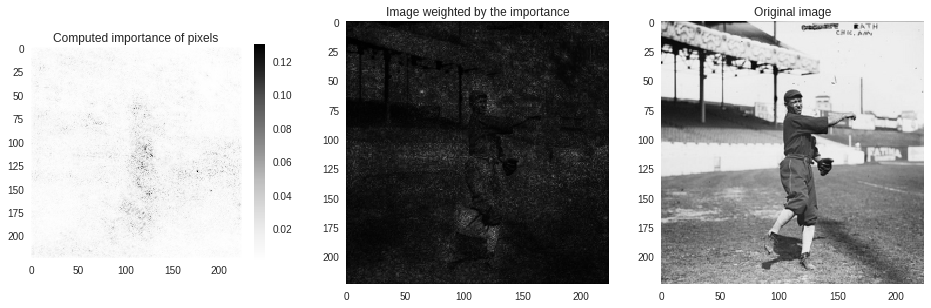

In [0]:
figsize(16, 10)
subplot(1,3,1)
imshow(importance_scores, cmap='viridis')
colorbar(shrink=0.4)
title('Computed importance of pixels')
grid(False)

subplot(1,3,2)
#normalize the scores to be <=1
w = importance_scores / importance_scores.max()
w = w ** 0.7 # a little gamma correction may make the image prettier
plt.imshow(img[0] * w[:,:,None])
title('Image weighted by the importance')
grid(False)

subplot(1,3,3)
plt.imshow(img[0])
title('Original image')
grid(False)

# Problem 2: Reusing a VGG Network [3p]

Training large-scale models takes much time and resources. It also requires caution when picking hyperparameters. It is a common practice to share learned parameters of large models, and reuse them in different tasks. Weight matrices can be shared, even between entirely different frameworks. Further reading: [How transferable are features in deep neural networks?](https://arxiv.org/abs/1411.1792) by Yosinski et al.

Neural networks trained for image classification might be seen as composed of two elements: a feature extractor, and a classifier. The former is typically made of a stack of convolutional layers, while the latter is the last linear layer of the model.

We will focus on the deepest models - VGG16 and/or VGG19. To complete the task, load pre-trained VGG model. Then:
1. **[2p]** Train the classifier part of the network on the
  [Caltech101](http://www.vision.caltech.edu/Image_Datasets/Caltech101/) dataset of images:
  * replace the classifier with a new randomly initialized one, whose output dimensionality matches
    the number of classes of the Caltech101 dataset. You can replace all layers in the classifier
    part of the VGG with just one affine projection into 102 classes.
  * to significantly reduce training time and avoid destroying network weights early in the training,
    train only the weights of the classifier. You can achieve this by applying the optimization only
    to the classifier's parameters.
    
2. **[1p]** Repeat the training in three scenarios: 
  * With dropout and data augmentation
  * Without dropout
  * Without dropout and without data augmentation.
  
  How does it influence training?
  
This procedure should quickly give you less than 10% training errors on the Caltech101 dataset!

In [0]:
vgg = VGG('vgg19')
if CUDA:
    vgg.cuda()

In [0]:
# List layers in the model
print 'Feature layers'
print '--------------'
for name, layer in zip(vgg.feature_names, vgg.features):
    print '{1: <12} {0: <8}  ({2}'.format(name, *str(layer).split('(', 1))
print '\nClassifier layers'
print '-----------------'
for layer in vgg.classifier:
    print '{: <12}({}'.format(*str(layer).split('(', 1))

Feature layers
--------------
Conv2d       conv1_1   (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu1_1   (inplace)
Conv2d       conv1_2   (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu1_2   (inplace)
MaxPool2d    pool1     (kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d       conv2_1   (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu2_1   (inplace)
Conv2d       conv2_2   (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu2_2   (inplace)
MaxPool2d    pool2     (kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d       conv3_1   (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu3_1   (inplace)
Conv2d       conv3_2   (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu3_2   (inplace)
Conv2d       conv3_3   (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU 

In [0]:
class SubsampledImageDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, indexes, transform, **kwargs):
        super(SubsampledImageDataset, self).__init__(**kwargs)
        self.dataset = dataset
        self.indexes = indexes
        self.transform = transform
    
    def __getitem__(self, i):
        img, label = self.dataset[self.indexes[i]]
        img = self.transform(img)
        return img, label
    
    def __len__(self):
        return len(self.indexes)

In [0]:
# fetch the data
![ -e 101_ObjectCategories.tar.gz ] || wget http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
![ -d 101_ObjectCategories ] || tar zxf 101_ObjectCategories.tar.gz

In [0]:
caltech_whole_dataset = torchvision.datasets.ImageFolder('./101_ObjectCategories/')

all_indexes = np.random.permutation(len(caltech_whole_dataset))
train_size = int(len(all_indexes) * 0.8)

caltech_train_dataset = SubsampledImageDataset(
    caltech_whole_dataset,
    all_indexes[:train_size],
    torchvision.transforms.Compose([
        torchvision.transforms.RandomResizedCrop(224),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
    ]))

caltech_test_dataset = SubsampledImageDataset(
    caltech_whole_dataset,
    all_indexes[train_size:],
    torchvision.transforms.Compose([
        torchvision.transforms.Resize(256),
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
    ]))

caltech_datasets = {
    'train': caltech_train_dataset,
    'test': caltech_test_dataset,
}

In [0]:
batch_size = 64

caltech_loaders = {
    'train': torch.utils.data.DataLoader(
        caltech_datasets['train'], batch_size=batch_size,
        num_workers=4,
        shuffle=True),
    'test': torch.utils.data.DataLoader(
        caltech_datasets['test'], batch_size=batch_size,
        num_workers=4,
        shuffle=False)}

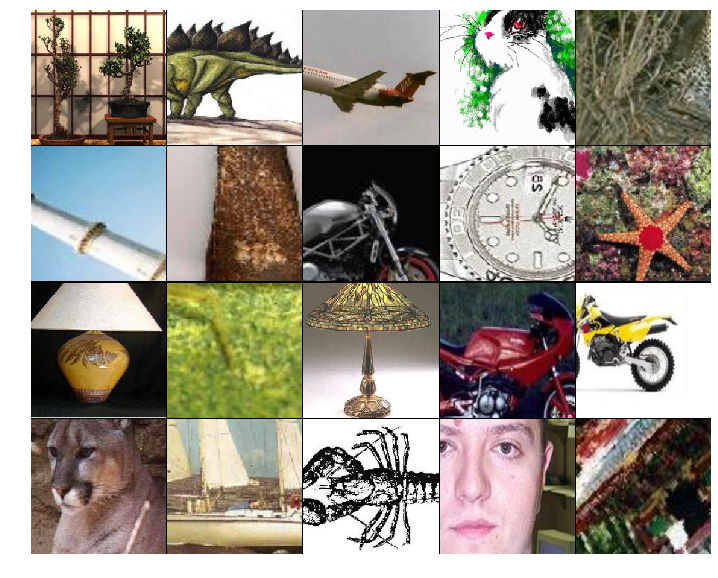

In [0]:
train_batch = next(iter(caltech_loaders['train']))
common.plotting.plot_mat(to_np(train_batch[0])[:20])

In [0]:
print '\nClassifier layers'
print '-----------------'
for layer in vgg.classifier:
    print '{: <12}({}'.format(*str(layer).split('(', 1))


Classifier layers
-----------------
Linear      (in_features=25088, out_features=4096, bias=True)
ReLU        (inplace)
Dropout     (p=0.5)
Linear      (in_features=4096, out_features=4096, bias=True)
ReLU        (inplace)
Dropout     (p=0.5)
Linear      (in_features=4096, out_features=1000, bias=True)


In [0]:
# Training code is based on assignment 4
def compute_error_rate(model, data_loader, cuda=True):
    model.eval()
    num_errs = 0.0
    num_examples = 0
    for x, y in data_loader:
        if cuda:
            x = x.cuda()
            y = y.cuda()
        with torch.no_grad():
            outputs = model.forward(x)
            _, predictions = outputs.max(dim=1)
            num_errs += (predictions != y).sum().item()
            num_examples += x.size(0)
    return 100.0 * num_errs / num_examples

        
def train(model, data_loaders, optimizer, num_epochs=1,
          log_every=100, cuda=True):
    if cuda:
        model.cuda()
    iter_ = 0
    epoch = 0
    best_params = None
    best_val_err = np.inf
    history = {'train_losses': [], 'train_errs': [], 'val_errs': []}
    print('Training the model!')
    print('You can interrupt it at any time.')
    try:
        while epoch < num_epochs:
            model.train()
            # model.train_mode()
            epoch += 1
            for x, y in data_loaders['train']:
                if cuda:
                    x = x.cuda()
                    y = y.cuda()
                iter_ += 1
                
                optimizer.zero_grad()
                out = model.forward(x)
                loss = criterion(out, y)
                loss.backward()
                optimizer.step()
                _, predictions = out.max(dim=1)
                err_rate = 100.0 * (predictions != y).sum() / out.size(0)

                history['train_losses'].append(loss.item())
                history['train_errs'].append(err_rate.item())

                if iter_ % log_every == 0:
                    print "Minibatch {0: >6}  | loss {1: >5.2f} | err rate {2: >5.2f}%" \
                          .format(iter_, loss.item(), err_rate)

            val_err_rate = compute_error_rate(model, data_loaders['test'], cuda)
            history['val_errs'].append((iter_, val_err_rate))

            if val_err_rate < best_val_err:
                best_epoch = epoch
                best_val_err = val_err_rate
            m = "After epoch {0: >2} | valid err rate: {1: >5.2f}% | doing {2: >3} epochs" \
                .format(epoch, val_err_rate, num_epochs)
            print '{0}\n{1}\n{0}'.format('-' * len(m), m)
    except KeyboardInterrupt:
        pass
    if best_params is not None:
        print "\nLoading best params on validation set (epoch %d)\n" %(best_epoch)
        model.parameters = best_params
    plot_history(history)

def plot_history(history):
    figsize(16, 4)
    subplot(1,2,1)
    train_loss = np.array(history['train_losses'])
    semilogy(np.arange(train_loss.shape[0]), train_loss, label='batch train loss')
    legend()
        
    subplot(1,2,2)
    train_errs = np.array(history['train_errs'])
    plot(np.arange(train_errs.shape[0]), train_errs, label='batch train error rate')
    val_errs = np.array(history['val_errs'])
    plot(val_errs[:,0], val_errs[:,1], label='validation error rate', color='r')
    ylim(0,20)
    legend()        

Training the model!
Minibatch     50  | loss  1.90 | err rate 42.00%
Minibatch    100  | loss  1.44 | err rate 32.00%
----------------------------------------------------------
After epoch  1 | valid err rate: 14.32% | doing 100 epochs
----------------------------------------------------------


Process Process-13:
Process Process-16:
Process Process-15:
Process Process-14:
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
Traceback (most recent call last):
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self._target(*self._args, **self._kwargs)
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python2.7/dist-packages/torch/utils/data/dataloader.py", line 96, 

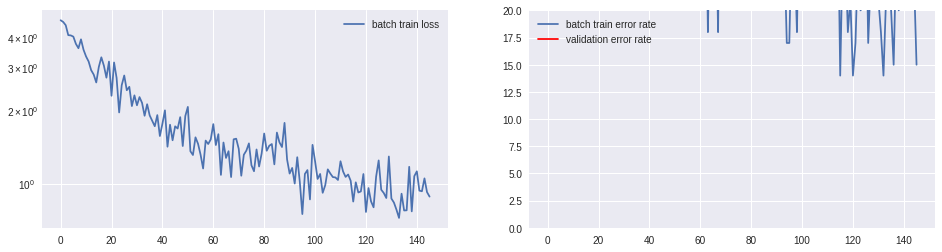

In [0]:

# TODO 
# implement a new classifier using `torch.nn.Sequential` and `torch.nn.Linear`
classifier = TODO

# Replace the classifier of our VGG network
vgg.classifier = classifier

# Disable gradient computation for the all parameter.
# It will speed up the backward pass - the gradient will not be
# backpropagated through the feature extractor.
for p in vgg.parameters():
    p.requires_grad = False

# Reenable gradient computation in our new classifier
for p in vgg.classifier.parameters():
    p.requires_grad = True

criterion = nn.NLLLoss()

# Train only the params of the classifier
optimizer = torch.optim.Adam(
    vgg.classifier.parameters(), lr=0.0001)

train(vgg, caltech_loaders, optimizer,
      num_epochs=10, log_every=50, cuda=True)

# Problem 3: A Neural Algorithm of Style [3p]

In 2015, Gatys et al. published [A Neural Algorithm of Style](https://arxiv.org/abs/1508.06576),
in which they demonstrates how to
generate images which preserve content of one one source image,
and the style of the other one. This allows to "transfer style",
e.g., from famous paintings to pictures taken with a digital camera.

Style transfer uses a pre-trained image recognition model.
Input image, initialized to random noise, is optimized in such a way,
so that patterns of activations in certain layers would match both
those of style and content. Weights of the network remain frozen,
as only the input image is being changed (through backpropagation).

Using pre-trained a VGG model, implement the artistic algotihm of style.
Begin by adding to the `VGG` class a function 

  `multi_layer_activations(x, layer_names)` .

It should take a list of layer names and input `x` as input, and return activations in those layers. Make sure   the function does it during a single forward pass.

Then:
* **[1p]** complete the code for style transfer and generate new, interesting images,
* **[1p]** by ommiting content loss generate textures based on input style paintings,
* **[1p]** implement [Google's DeepDream](https://research.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html) using the VGG network and generate more interesting images.

In [0]:
![ -e images.tar.bz2 ] || gdown 'https://drive.google.com/uc?id=18y17PXpo_Qwt2l_FF_7ODJYcQYEExOeF' -O images.tar.bz2
![ -d images ] || tar jxf images.tar.bz2

In [0]:
!ls images

arab_text.jpg	   hoovertowernight.jpg      starry_night_google.jpg
brad_pitt.jpg	   picasso_selfport1907.jpg  starry_night.jpg
crowd.jpg	   pl_text.jpg		     the_scream.jpg
escher_sphere.jpg  seated-nude.jpg	     tubingen.jpg
frida_kahlo.jpg    shipwreck.jpg	     woman-with-hat-matisse.jpg
golden_gate.jpg    starry_night_crop.png     wood.jpeg


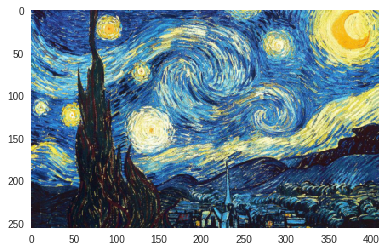

In [0]:
def load_image(path, size=256):
        img = PIL.Image.open(path)
        img = img.convert('RGB')
        img = torchvision.transforms.Scale(size)(img)
        return numpy.asarray(img).astype('float32') / 255.0

imshow(load_image('images/starry_night.jpg'))
grid(False)

In [0]:
class StyleTransferNet(object):
    def __init__(self, style_layers, content_layers, vgg_model='vgg19',
                 content_weight=5e0, style_weight=1e2):
        self.style_layers = style_layers
        self.style_captures = []
        self.style_weight = style_weight
        self.content_layers = content_layers
        self.content_captures = []
        self.content_weight = content_weight
        self.vgg = VGG(vgg_model)
        self.vgg.eval()
        for p in self.vgg.parameters():
            p.requires_grad = False
        self.mse = nn.MSELoss()
        
    def capture_content(self, x):
        # TODO
        # implement saving naural activations for a chosen set of content layers
        self.content_captures = TODO
    
    def capture_style(self, x):
        style_layers = self.vgg.multi_layer_activations(
            x, self.style_layers)
        self.style_captures = [self._gram_mat(l) for l in style_layers]

    def get_loss(self, x):
        needed_layers = self.content_layers + self.style_layers
        needed_values = self.vgg.multi_layer_activations(
            x, needed_layers)
        content_values = needed_values[:len(self.content_layers)]
        style_values = needed_values[len(self.content_layers):]
        
        self.content_losses = []
        self.style_losses = []
        
        # TODO:
        # append onto the lists  self.content_losses and self.style_losses 
        # the L2 (euclidean) distances between the captured statistics and the 
        # reconstructed image's ones. Remember about applying the gram matrix to style!
        # You can use the self.mse to compute the L2 distance
        
        loss = sum(self.content_losses) * self.content_weight
        loss += sum(self.style_losses) * self.style_weight
        
        return loss
            
    def _gram_mat(self, x):
        """
        Compute the matrix of feature correlations.
        
        Input:
            x: tensor of size batch_size x num_channels x width x heigth
        
        Output:
            tensor of size batch_size x num_chanels x num_channels given by the formula
            
            out[b, c1, c2] = 1/width 1/heigth \sum_w=1^width \sum_h=1^heigth x[b, c1, w, h] * x[b, c2, w, h]
        """
        # TODO
        # Compute the Gram matrix, as defined in the docstring. Try to implement it as efficiently as possible.
        pass

In [0]:
# TODO find a giid set of layers for the content and style images.
model = StyleTransferNet(
    style_layers=[TODO],
    content_layers=[TODO], content_weight=10e0)

if CUDA:
    model.vgg.cuda()

In [0]:
style_img_path = 'images/starry_night.jpg'
content_img_path = 'images/golden_gate.jpg'

style_img_size = 256
content_img_size = 256

style_image = load_image(style_img_path, style_img_size)
content_image = load_image(content_img_path, content_img_size)
content_shape = content_image.shape

print 'Capturing content'
model.capture_content(to_tensor(content_image))

print 'Capturing style'
model.capture_style(to_tensor(style_image))

Capturing content
Capturing style


In [0]:
# image = load_image(content_img_path, 512)
image = np.random.randn(*content_shape).astype(np.float32) * 0.01 + 0.5
image = to_tensor(image, requires_grad=True)

# try using Adam or LBFGS

#optimizer = torch.optim.Adam([image], lr=0.001)  #, momentum=0.5)
optimizer = torch.optim.LBFGS([image])

Iteration     73 | loss 32.4989624


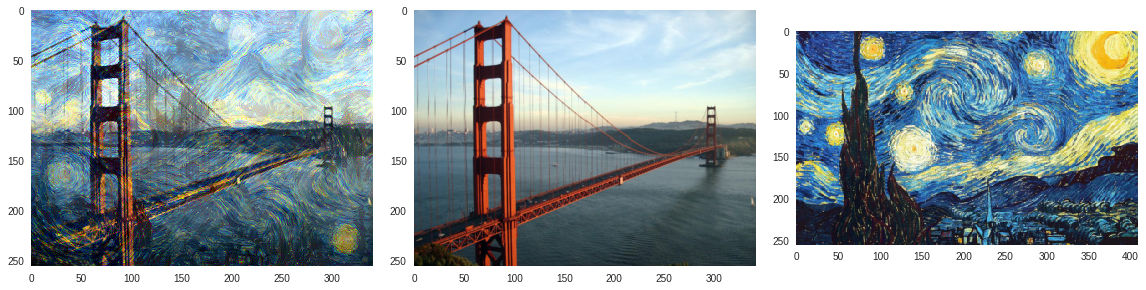

In [0]:
from IPython import display

# Training loop
max_iters = 500
check_every = 5
old_loss = np.inf
loss_type = 'adam'
tolerance = 0.00001
try:
    fig = figure(figsize=(16, 10))
    fig.add_subplot(132).imshow(content_image)
    grid(False)
    fig.add_subplot(133).imshow(style_image)
    grid(False)
    ax = fig.add_subplot(131)
    
    tight_layout()
    imsh = ax.imshow(to_np(image))
    grid(False)
    for iter_ in range(max_iters):
        
        def closure():
            optimizer.zero_grad()
            loss = model.get_loss(image)
            # print('loss:', loss.data.cpu().numpy()[0])
            loss.backward()
            return loss
        
        if loss_type == 'adam':
            #loss = model.get_loss(image)
            #loss.backward()
            loss = optimizer.step(closure)
            image.grad.data.zero_()
        elif loss_type == 'lbfgs':
            loss = optimizer.step(closure)
        else:
            raise ValueError
        #image.data = image.data.clip(0, 1)
            
        if iter_ % check_every == 0:
            display.clear_output(wait=True)
            imsh.set_data(np.clip(to_np(image), 0.0, 1.0))
            #ax.imshow(np.clip(to_np(image), 0.0, 1.0))
            display.display(fig)
            
            
            print "Iteration {0: >6} | loss {1: >10.7f}".format(iter_, loss.item())
            for i, l in enumerate(model.content_losses):
                print '  Content loss {}: {: >8.4f}'.format(i + 1, l.item() * model.content_weight)
            for i, l in enumerate(model.style_losses):
                print '  Style loss {}: {: >10.4f}'.format(i + 1, l.item() * model.style_weight)
            
        old_loss = loss.data[0]
except KeyboardInterrupt:
    display.clear_output(wait=True)
    print "Iteration {0: >6} | loss {1: >10.7f}".format(iter_, loss.item())

# Bonus Problems

**[2p]** implement [Google's DeepDream](https://research.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html) using the VGG network and generate more interesting images.

**[2p]** select a few neurons in each layer and try to find images to which the respond the most. Then visualize the gradient with respect to the input pixels at the mostly exciting patches. Try to recreate the figure 2 from M. Zieler Visualizing and Understanding Convolutional Neural Networks (https://arxiv.org/pdf/1311.2901.pdf)